In [4]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import copy


#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [5]:
def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    
    
    I = np.array(np.eye(A.shape[0]))
    gammaW = np.array(np.eye(A.shape[0]))

    K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + R)

    if y is not None:
        new_info = (y - C@xhat_fm)
        new_info[np.isnan(new_info)] = 0
        xhat_fp = xhat_fm + K_f@new_info
        
        P_fp = (I - K_f@C)@P_fm
        xhat_fm = A@xhat_fp + B@u
        P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T
        
    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, R, Q):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    :return:
    """
    if u is None:
        u = np.array(np.zeros([B.shape[1], y.shape[1]]))

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, [-1]], P_fm[-1], y[:, [i]], u[:, [i]],
                                                                     A, B, C, R, Q)
        
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))

        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A):
    """
    :param xhat_fp:
    :param xhat_fm:
    :param P_fp:
    :param P_fm:
    :param A:
    :return:
    """
    N = xhat_fp.shape[1]

    xhat_smooth = copy.copy(xhat_fp)
    P_smooth = copy.copy(P_fp)
    for t in range(N-2, -1, -1):
        L = P_fp[t]@A.T@np.linalg.pinv(P_fm[t])
        xhat_smooth[:, [t]] = xhat_fp[:, [t]] + L@(xhat_smooth[:, [t+1]] - xhat_fm[:, [t+1]])
        P_smooth[t] = P_fp[t] - L@(P_smooth[t+1] - P_fm[t+1])

    return xhat_smooth, P_smooth

## Load data

In [6]:
dir='~/DataAnalysis/data/Sprints/HighRes/KF/'

In [14]:
data_1=pd.read_hdf(dir+'AllPredictions.h5')
data_2=pd.read_hdf(dir+'WindyMASigned.h5')

Text(0, 0.5, 'True Distance, m')

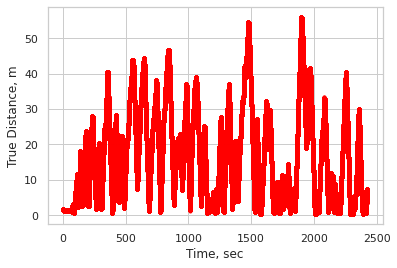

In [15]:
plt.plot(data_2.time, data_2.distance_from_source, '.', color='red')
plt.xlabel('Time, sec')
plt.ylabel('True Distance, m')

## Estimate velocity towards/away from source

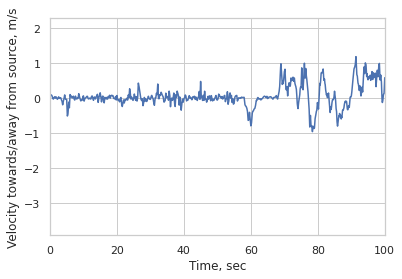

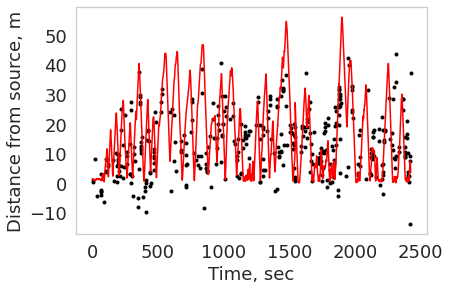

In [16]:
wind_vector = np.vstack((data_2.U.values, data_2.V.values)).T
wind_magnitude = np.linalg.norm(wind_vector, axis=1)
unit_wind_vector = wind_vector / np.vstack((wind_magnitude, wind_magnitude)).T


velocity_vector = np.vstack((data_2.ground_speed_x.values, data_2.ground_speed_y.values)).T

# There is probably a more efficient syntax
velocity_ground_relative_to_wind = [np.dot(velocity_vector[i,:], unit_wind_vector[i,:]) for i in range(len(velocity_vector))]
plt.plot(data_2.time, velocity_ground_relative_to_wind)
plt.xlim(0, 100)

plt.xlabel('Time, sec')
plt.ylabel('Velocity towards/away from source, m/s')


data_for_kf_original = pd.DataFrame({'time': data_2.time, 
                                'velocity_ground_relative_to_wind': velocity_ground_relative_to_wind,
                                'distance_true': data_2.distance_from_source,
                                'distance_odor_observed': np.nan*np.ones_like(velocity_ground_relative_to_wind)})
# kalman filter is slow, let's subsample the data
data_for_kf = copy.copy( data_for_kf_original[::20] )
# put distance from odor predictions in the right places
for ix_odor in data_1.index:
    ix_kf = np.argmin( np.abs(data_1.mean_whiff_time[ix_odor] - data_for_kf.time))
    data_for_kf.distance_odor_observed.iloc[ix_kf] = data_1.predicted_distance.loc[ix_odor]
#     print(data_for_kf.distance_odor_observed[ix_kf])
f,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(data_for_kf.time, data_for_kf.distance_odor_observed, '.', color='black')
ax.plot(data_for_kf.time, data_for_kf.distance_true, color='red')
ax.grid(False)

ax.set_xlabel('Time, sec')
ax.set_ylabel('Distance from source, m')

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)

## Define states and measurements

In [17]:
dt = np.median(np.diff(data_for_kf.time.values))
y = np.array([data_for_kf.distance_odor_observed.values, 
              data_for_kf.velocity_ground_relative_to_wind.values])

### Define dynamics: assume constant velocity

# constant velocity
A = np.array([[1, dt], [0, 1]])

# no explicit control inputs
B = np.array([[0], [0]])

# we have measurements of distance and velocity
C = np.array([[1, 0], [0, 1]])


### Define covariances
# measurement covariances: the measurements of the observed distance are worse than the velocity measurements
R = np.array([[1e-1, 0], [0, 1e-3]])

# model covariances: the model for constant velocity is probably worse than the model for distance = integral of velocity
Q = np.array([[1e-3, 0], [0, 1e-1]])

### Define initial conditions
x0 = np.array([[0], [0]])
P0 = np.array(100*np.eye(2))
u = None # control input -- technically this could be the acceleration, but not needed

### Choose a subset of the measurements for testing
ix_start = 0
ix_end = 100000

y_subset = copy.copy( y[:, ix_start:ix_end] )
y_subset[0,0] = 5 # start with a guess for initial distance (can't be nan)

time = data_for_kf.time[ix_start:ix_end].values

### Run the filter and smoother
xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, y_subset, u, A, B, C, R, Q)
xhat_smooth, _ = __kalman_backward_smooth__(xhat_fp, xhat_fm, P_fp, P_fm, A)


## Plot Results

median error:  4.4916273298566844  meters


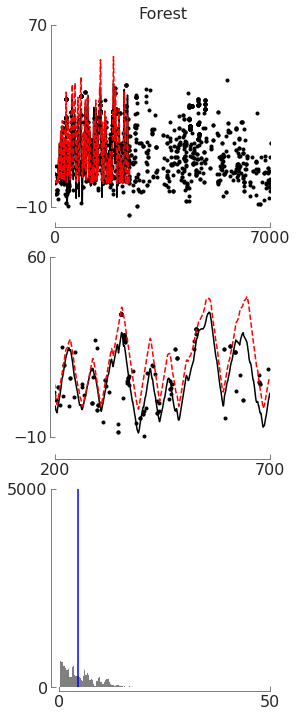

In [18]:
f,(ax,ax1,ax2)=plt.subplots(3,1,figsize=(4,10))

ax.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', color='black', label='Predicted Distance')
ax.plot(time, xhat_smooth[0,:], color='black', label='Smoothed Distance')
ax.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red',label='True Distance')

ax.set_xlim(0, 7000)

ax.grid(False)
mpl_functions.adjust_spines(ax,['left','bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=[-10,70],
                            xticks=[0,7000],
                            linewidth=0.5)
# ax.axvspan(0, 4000,  alpha=0.2, color='grey')
# ax.set_xlabel('Time, s')
# ax.set_ylabel('Distance, m')
ax.set_title('Forest')
# ax.legend( bbox_to_anchor=(1,1))
# ax.legend(loc='best')


ax1.plot(data_1.mean_whiff_time, data_1.predicted_distance, '.', color='black', label='Predicted Distance')
ax1.plot(time, xhat_smooth[0,:], color='black')
ax1.plot(data_for_kf.time, data_for_kf.distance_true, '--', color='red',label='True Distance')

lim=[200,700]
ax1.set_xlim(lim)
ax1.grid(False)

mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'bottom':4, 'left':5},
#                             smart_bounds=True,
                            yticks=[-10,60],
                            xticks=lim,
                            linewidth=0.5)
# ax1.set_xlabel('Time, s')
# ax1.set_ylabel('Distance, m')
# ax1.set_title('Zoomed')

## Plotting Error
error = xhat_smooth[0,:] - data_for_kf.distance_true.values
h = plt.hist( np.abs(error), bins=100, color='gray',histtype='stepfilled')
median_error = np.median(np.abs(error))
print('median error: ', median_error, ' meters')



ax2.axvline(median_error, 0, np.max(h[0]),color='blue')
ax2.grid(False)
# ax2.set_xlabel('Error, m')
mpl_functions.adjust_spines(ax2,['left', 'bottom'],
                            spine_locations={'left':4,'bottom':4},
                            smart_bounds=True,
                            yticks=[0,5000],
                            xticks=[0,50],
                            linewidth=0.5)

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 16)


## 

In [24]:
f.savefig('../../Figure/ppt/DesertOnForest.jpeg', dpi=300, bbox_inches = "tight")